# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
from layers import FullyConnectedLayer, ReLULayer
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_fc1
Gradient check passed!
Checking gradient for B_fc1
Gradient check passed!
Checking gradient for W_fc2
Gradient check passed!
Checking gradient for B_fc2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_fc1
Gradient check passed!
Checking gradient for B_fc1
Gradient check passed!
Checking gradient for W_fc2
Gradient check passed!
Checking gradient for B_fc2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [34]:
from model import TwoLayerNet
from metrics import multiclass_accuracy

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [48]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.311037, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257201, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299850, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211899, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.189323, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.225371, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.346309, Train accuracy: 0.207556, val accuracy: 0.215000
Loss: 2.125317, Train accuracy: 0.234333, val accuracy: 0.238000
Loss: 2.107688, Train accuracy: 0.258222, val accuracy: 0.258000
Loss: 2.038596, Train accuracy: 0.268556, val accuracy: 0.267000
Loss: 2.176081, Train accuracy: 0.282889, val accuracy: 0.290000
Loss: 1.980822, Train accuracy: 0.313778, val accuracy: 0.317000
Loss: 1.734718, Train accuracy: 0.345556, val accuracy: 0.345000
Loss: 1.712075, Train acc

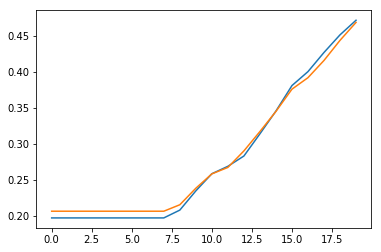

In [49]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [50]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5 * initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.258367, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.172082, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315996, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.084472, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201596, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324979, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.082897, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.097376, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.018531, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.007963, Train accuracy: 0.218111, val accuracy: 0.224000
Loss: 2.037898, Train accuracy: 0.238556, val accuracy: 0.241000
Loss: 2.157339, Train accuracy: 0.258556, val accuracy: 0.258000
Loss: 1.624162, Train accuracy: 0.269000, val accuracy: 0.268000
Loss: 1.854634, Train accuracy: 0.284778, val accuracy: 0.285000
Loss: 1.745950, Train accuracy: 0.305222, val accuracy: 0.307000
Loss: 1.880715, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [51]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.254431, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.046629, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278383, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.220667, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269846, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.188904, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.327077, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.207343, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.194498, Train accuracy: 0.197333, val accuracy: 0.207000
Loss: 1.972097, Train accuracy: 0.212222, val accuracy: 0.220000
Loss: 2.043638, Train accuracy: 0.226667, val accuracy: 0.230000
Loss: 2.079393, Train accuracy: 0.242667, val accuracy: 0.247000
Loss: 2.163382, Train accuracy: 0.253778, val accuracy: 0.250000
Loss: 2.252759, Train accuracy: 0.266556, val accuracy: 0.262000
Loss: 2.133518, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [52]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.339114, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312515, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294804, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.302629, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.302958, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.326006, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302982, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.281074, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.205450, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.250561, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.010600, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.997571, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.054280, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.224979, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.751031, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.776247, Train acc

Loss: 1.170638, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.160649, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.437978, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.376946, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.460407, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.388319, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.416314, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.164076, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.217434, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.367667, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.388327, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.225609, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.278708, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.142615, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.224222, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.195536, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [104]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 150, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=4e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.303778, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.263931, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.183918, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 3.041951, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 3.638033, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.382135, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 2.398126, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 1.407563, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 3.730900, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.329557, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 4.929495, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 3.335847, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.476671, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 1.417217, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.213315, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 0.091245, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [116]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 4e-1, 1e-2]
reg_strength = [1e-7, 4e-7, 1e-8]
learning_rate_decay = [0.999]
hidden_layer_size = [100, 128, 175]
num_epochs = 100
batch_size = [64, 50, 80]

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

for lr in learning_rates:
    for rs in reg_strength:
        for lrd in learning_rate_decay:
            for hl in hidden_layer_size:
                for bs in batch_size:
                    model = TwoLayerNet(n_input=train_X.shape[1], 
                            n_output=10,
                            hidden_layer_size=hl,
                            reg=rs)
                    dataset = Dataset(train_X, train_y, val_X, val_y)
                    trainer = Trainer(model, 
                                      dataset, 
                                      SGD(), 
                                      learning_rate=lr, 
                                      num_epochs=num_epochs, 
                                      batch_size=bs,
                                      learning_rate_decay=lrd)
                    print('__________________________________________________________________')
                    print('''learning_rate={lr} reg_strength={rs} learning_rate_decay={lrd} hidden_layer_size={hl} batch_size={bs}'''.format(
                        lr=lr,
                        rs=rs,
                        lrd=lrd,
                        hl=hl,
                        bs=bs))
                    loss_history, train_history, val_history = trainer.fit()
                    print('best val acc = {}, epoch_n={}'.format(max(val_history), np.argmax(val_history)))
                    

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

#print('best validation accuracy achieved: %f' % best_val_accuracy)

__________________________________________________________________
learning_rate=0.1 reg_strength=1e-07 learning_rate_decay=0.999 hidden_layer_size=100 batch_size=64
Loss: 2.268704, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.138287, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.090935, Train accuracy: 0.215556, val accuracy: 0.215000
Loss: 2.040243, Train accuracy: 0.267222, val accuracy: 0.278000
Loss: 2.007209, Train accuracy: 0.340222, val accuracy: 0.345000
Loss: 1.446407, Train accuracy: 0.427667, val accuracy: 0.414000
Loss: 1.313518, Train accuracy: 0.501556, val accuracy: 0.504000
Loss: 1.584089, Train accuracy: 0.529667, val accuracy: 0.536000
Loss: 1.371615, Train accuracy: 0.569000, val accuracy: 0.553000
Loss: 1.237298, Train accuracy: 0.625667, val accuracy: 0.608000
Loss: 1.314605, Train accuracy: 0.625667, val accuracy: 0.615000
Loss: 1.400989, Train accuracy: 0.649111, val accuracy: 0.628000
Loss: 1.231049, Train accuracy: 0.650889, val accuracy

Loss: 0.730940, Train accuracy: 0.799222, val accuracy: 0.716000
Loss: 0.662643, Train accuracy: 0.812000, val accuracy: 0.728000
Loss: 0.882425, Train accuracy: 0.828889, val accuracy: 0.733000
Loss: 0.511988, Train accuracy: 0.824111, val accuracy: 0.732000
Loss: 0.544062, Train accuracy: 0.806111, val accuracy: 0.722000
Loss: 0.409449, Train accuracy: 0.844333, val accuracy: 0.746000
Loss: 0.717142, Train accuracy: 0.823889, val accuracy: 0.722000
Loss: 0.486265, Train accuracy: 0.841444, val accuracy: 0.730000
Loss: 0.761491, Train accuracy: 0.831778, val accuracy: 0.715000
Loss: 0.743702, Train accuracy: 0.828778, val accuracy: 0.718000
Loss: 0.475338, Train accuracy: 0.868556, val accuracy: 0.745000
Loss: 0.437401, Train accuracy: 0.865889, val accuracy: 0.744000
Loss: 0.402048, Train accuracy: 0.873111, val accuracy: 0.740000
Loss: 0.577190, Train accuracy: 0.854778, val accuracy: 0.725000
Loss: 0.676567, Train accuracy: 0.877778, val accuracy: 0.749000
Loss: 0.508559, Train acc

Loss: 0.503767, Train accuracy: 0.848444, val accuracy: 0.732000
Loss: 0.311804, Train accuracy: 0.858222, val accuracy: 0.740000
Loss: 0.486988, Train accuracy: 0.830556, val accuracy: 0.714000
Loss: 0.407338, Train accuracy: 0.860222, val accuracy: 0.735000
Loss: 0.367389, Train accuracy: 0.871556, val accuracy: 0.734000
Loss: 0.518513, Train accuracy: 0.873111, val accuracy: 0.736000
Loss: 0.390474, Train accuracy: 0.879667, val accuracy: 0.741000
Loss: 0.479368, Train accuracy: 0.870778, val accuracy: 0.728000
Loss: 0.401391, Train accuracy: 0.880333, val accuracy: 0.752000
Loss: 0.550201, Train accuracy: 0.842667, val accuracy: 0.705000
Loss: 0.458198, Train accuracy: 0.822778, val accuracy: 0.710000
Loss: 0.501546, Train accuracy: 0.819778, val accuracy: 0.706000
Loss: 0.288947, Train accuracy: 0.897333, val accuracy: 0.738000
Loss: 0.348974, Train accuracy: 0.883889, val accuracy: 0.720000
Loss: 0.584921, Train accuracy: 0.890556, val accuracy: 0.743000
Loss: 0.452616, Train acc

Loss: 0.288921, Train accuracy: 0.944000, val accuracy: 0.759000
Loss: 0.195964, Train accuracy: 0.941000, val accuracy: 0.754000
Loss: 0.138970, Train accuracy: 0.955000, val accuracy: 0.755000
Loss: 0.128924, Train accuracy: 0.954444, val accuracy: 0.760000
Loss: 0.329293, Train accuracy: 0.914778, val accuracy: 0.743000
Loss: 0.194800, Train accuracy: 0.942889, val accuracy: 0.753000
Loss: 0.242936, Train accuracy: 0.932889, val accuracy: 0.727000
Loss: 0.115143, Train accuracy: 0.942556, val accuracy: 0.732000
Loss: 0.335316, Train accuracy: 0.930000, val accuracy: 0.743000
Loss: 0.240616, Train accuracy: 0.961222, val accuracy: 0.757000
Loss: 0.465084, Train accuracy: 0.928000, val accuracy: 0.752000
Loss: 0.222476, Train accuracy: 0.953444, val accuracy: 0.756000
Loss: 0.167733, Train accuracy: 0.950667, val accuracy: 0.755000
Loss: 0.145027, Train accuracy: 0.958000, val accuracy: 0.760000
Loss: 0.043436, Train accuracy: 0.962111, val accuracy: 0.762000
Loss: 0.112048, Train acc

Loss: 0.213440, Train accuracy: 0.977556, val accuracy: 0.759000
Loss: 0.071329, Train accuracy: 0.978889, val accuracy: 0.766000
Loss: 0.110609, Train accuracy: 0.986444, val accuracy: 0.771000
Loss: 0.062159, Train accuracy: 0.985444, val accuracy: 0.777000
Loss: 0.081138, Train accuracy: 0.982333, val accuracy: 0.762000
Loss: 0.101960, Train accuracy: 0.985444, val accuracy: 0.772000
Loss: 0.072812, Train accuracy: 0.970889, val accuracy: 0.746000
Loss: 0.037806, Train accuracy: 0.989333, val accuracy: 0.774000
Loss: 0.034297, Train accuracy: 0.975111, val accuracy: 0.753000
Loss: 0.068037, Train accuracy: 0.991444, val accuracy: 0.777000
best val acc = 0.777, epoch_n=93
__________________________________________________________________
learning_rate=0.1 reg_strength=1e-07 learning_rate_decay=0.999 hidden_layer_size=128 batch_size=80
Loss: 2.273287, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319803, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.164126, Train

Loss: 0.922986, Train accuracy: 0.678667, val accuracy: 0.669000
Loss: 1.108164, Train accuracy: 0.661556, val accuracy: 0.650000
Loss: 1.240351, Train accuracy: 0.695111, val accuracy: 0.685000
Loss: 1.115514, Train accuracy: 0.708556, val accuracy: 0.699000
Loss: 0.774619, Train accuracy: 0.697889, val accuracy: 0.679000
Loss: 0.870556, Train accuracy: 0.735000, val accuracy: 0.702000
Loss: 0.630485, Train accuracy: 0.747889, val accuracy: 0.720000
Loss: 0.667210, Train accuracy: 0.755333, val accuracy: 0.720000
Loss: 0.828156, Train accuracy: 0.763222, val accuracy: 0.713000
Loss: 0.718062, Train accuracy: 0.775778, val accuracy: 0.730000
Loss: 1.227559, Train accuracy: 0.729111, val accuracy: 0.688000
Loss: 0.450150, Train accuracy: 0.769444, val accuracy: 0.694000
Loss: 0.859962, Train accuracy: 0.746778, val accuracy: 0.698000
Loss: 0.642114, Train accuracy: 0.802556, val accuracy: 0.731000
Loss: 0.845864, Train accuracy: 0.796889, val accuracy: 0.726000
Loss: 0.898226, Train acc

Loss: 0.607369, Train accuracy: 0.875444, val accuracy: 0.748000
Loss: 0.359506, Train accuracy: 0.881444, val accuracy: 0.754000
Loss: 0.439061, Train accuracy: 0.881889, val accuracy: 0.748000
Loss: 0.444997, Train accuracy: 0.902222, val accuracy: 0.766000
Loss: 0.261934, Train accuracy: 0.904889, val accuracy: 0.765000
Loss: 0.241956, Train accuracy: 0.892778, val accuracy: 0.748000
Loss: 0.275950, Train accuracy: 0.904000, val accuracy: 0.759000
Loss: 0.575463, Train accuracy: 0.893333, val accuracy: 0.752000
Loss: 0.335675, Train accuracy: 0.910889, val accuracy: 0.754000
Loss: 0.266991, Train accuracy: 0.912333, val accuracy: 0.763000
Loss: 0.303822, Train accuracy: 0.906778, val accuracy: 0.765000
Loss: 0.401008, Train accuracy: 0.918556, val accuracy: 0.757000
Loss: 0.275238, Train accuracy: 0.925667, val accuracy: 0.761000
Loss: 0.407796, Train accuracy: 0.889778, val accuracy: 0.742000
Loss: 0.190703, Train accuracy: 0.932333, val accuracy: 0.769000
Loss: 0.286031, Train acc

KeyboardInterrupt: 

In [118]:
# Assume that the best model is achieved with the following parameters
# learning_rate=0.1 
# reg_strength=1e-07 
# learning_rate_decay=0.999 
# hidden_layer_size=175 
# batch_size=64
# num_epochs = 100

model = TwoLayerNet(n_input=train_X.shape[1], 
                            n_output=10,
                            hidden_layer_size=175,
                            reg=1e-7)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, 
                  dataset, 
                  SGD(), 
                  learning_rate=0.1, 
                  num_epochs=100, 
                  batch_size=64,
                  learning_rate_decay=0.999)
loss_history, train_history, val_history = trainer.fit()

Loss: 2.238640, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289317, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.034614, Train accuracy: 0.227111, val accuracy: 0.227000
Loss: 1.908860, Train accuracy: 0.290222, val accuracy: 0.295000
Loss: 1.688448, Train accuracy: 0.381444, val accuracy: 0.367000
Loss: 1.918162, Train accuracy: 0.448222, val accuracy: 0.452000
Loss: 1.429039, Train accuracy: 0.524000, val accuracy: 0.517000
Loss: 1.279020, Train accuracy: 0.581222, val accuracy: 0.577000
Loss: 1.194392, Train accuracy: 0.620556, val accuracy: 0.598000
Loss: 1.325787, Train accuracy: 0.630333, val accuracy: 0.618000
Loss: 0.771738, Train accuracy: 0.678889, val accuracy: 0.659000
Loss: 0.949286, Train accuracy: 0.694889, val accuracy: 0.675000
Loss: 1.033222, Train accuracy: 0.695333, val accuracy: 0.671000
Loss: 1.092214, Train accuracy: 0.716889, val accuracy: 0.682000
Loss: 1.017662, Train accuracy: 0.712778, val accuracy: 0.692000
Loss: 1.011926, Train acc

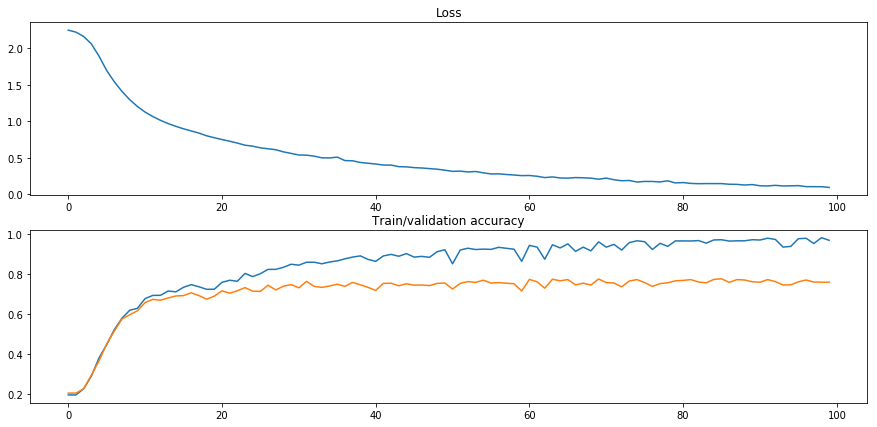

In [119]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [122]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.743000
